In [1]:
BATCH_SIZE = 32
MAX_LEN = 512
EMBEDDING_DIMS = 300
NUM_CLASSES = 9
NUM_TRAIN = 5893
NUM_TEST = 1474

In [2]:
import tensorflow as tf

def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([MAX_LEN, EMBEDDING_DIMS], dtype=tf.float32),
            'Y': tf.FixedLenFeature((NUM_CLASSES,), dtype=tf.float32)
        })
    
    X = features['X']
    Y = features['Y']
    
    return X, Y

In [3]:
def iterator(tfrecord_path, data_len):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).batch(data_len)
    iterator = dataset.make_one_shot_iterator()

    X, Y = iterator.get_next()
    X = tf.reshape(X, [-1, MAX_LEN, EMBEDDING_DIMS])
    
    return X, Y

In [4]:
%%time

x_train, y_train = iterator('train.tfrecord', NUM_TRAIN)
x_test, y_test = iterator('test.tfrecord', NUM_TEST)

x_train = tf.Session().run(x_train)
y_train = tf.Session().run(y_train)
x_test = tf.Session().run(x_test)
y_test = tf.Session().run(y_test)

CPU times: user 25.3 s, sys: 5.75 s, total: 31 s
Wall time: 30 s


In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5893, 512, 300), (5893, 9), (1474, 512, 300), (1474, 9))

In [6]:
hidden_dims = 50
epochs = 5

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Flatten
from keras.layers.wrappers import Bidirectional

model = Sequential()
model.add(Bidirectional(CuDNNLSTM(hidden_dims, return_sequences=True),
                            input_shape=(MAX_LEN, EMBEDDING_DIMS)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 512, 100)          140800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512, 100)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 460809    
Total params: 601,609
Trainable params: 601,609
Non-trainable params: 0
_________________________________________________________________


In [8]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [9]:
%%time

hist = model.fit(x_train,
                 y_train,
                batch_size=BATCH_SIZE,
                epochs=epochs,
                validation_data=(x_test, y_test))

Train on 5893 samples, validate on 1474 samples
Epoch 1/5
5893/5893 [==============================] - 22s 4ms/step - loss: 0.6772 - acc: 0.7670 - val_loss: 0.4189 - val_acc: 0.8609
Epoch 2/5
5893/5893 [==============================] - 20s 3ms/step - loss: 0.1258 - acc: 0.9633 - val_loss: 0.4792 - val_acc: 0.8541
Epoch 3/5
5893/5893 [==============================] - 20s 3ms/step - loss: 0.0360 - acc: 0.9919 - val_loss: 0.5018 - val_acc: 0.8657
Epoch 4/5
5893/5893 [==============================] - 20s 3ms/step - loss: 0.0086 - acc: 0.9986 - val_loss: 0.4543 - val_acc: 0.8799
Epoch 5/5
5893/5893 [==============================] - 20s 3ms/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.4260 - val_acc: 0.9003
CPU times: user 1min 43s, sys: 9.61 s, total: 1min 52s
Wall time: 1min 42s


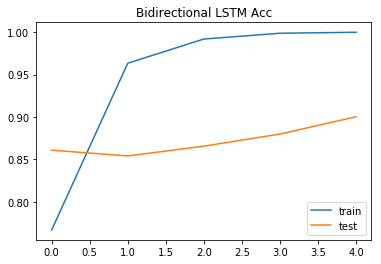

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Bidirectional LSTM Acc')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

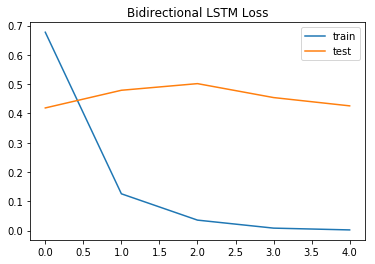

In [11]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Bidirectional LSTM Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [12]:
import numpy as np

pred_values_orig = model.predict(x_test)
pred_values = np.argmax(pred_values_orig, axis=1)
print('shape of pred_values:', pred_values.shape)
y_test = np.argmax(y_test, axis=1)
print('shape of y_test:', y_test.shape)

shape of pred_values: (1474,)
shape of y_test: (1474,)


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel',\
                'livedoor-homme', 'movie-enter', 'peachy', 'smax',\
                'sports-watch', 'topic-news']

result = classification_report(y_test, pred_values, digits=3, target_names=target_names)

print(result)

                precision    recall  f1-score   support

dokujo-tsushin      0.850     0.874     0.862       175
  it-life-hack      0.851     0.929     0.888       154
 kaden-channel      0.957     0.928     0.942       167
livedoor-homme      0.786     0.675     0.726       114
   movie-enter      0.860     0.989     0.920       174
        peachy      0.886     0.761     0.819       184
          smax      0.957     0.957     0.957       186
  sports-watch      0.969     0.957     0.963       163
    topic-news      0.950     0.975     0.962       157

     micro avg      0.900     0.900     0.900      1474
     macro avg      0.896     0.894     0.893      1474
  weighted avg      0.900     0.900     0.899      1474



Normalized confusion matrix
[[0.874 0.006 0.    0.034 0.029 0.034 0.    0.006 0.017]
 [0.013 0.929 0.026 0.013 0.    0.    0.013 0.006 0.   ]
 [0.    0.03  0.928 0.    0.    0.018 0.024 0.    0.   ]
 [0.053 0.096 0.018 0.675 0.088 0.044 0.009 0.018 0.   ]
 [0.006 0.006 0.    0.    0.989 0.    0.    0.    0.   ]
 [0.098 0.011 0.005 0.065 0.049 0.761 0.    0.005 0.005]
 [0.    0.027 0.    0.    0.    0.016 0.957 0.    0.   ]
 [0.    0.    0.    0.006 0.012 0.    0.    0.957 0.025]
 [0.    0.    0.    0.    0.013 0.006 0.006 0.    0.975]]


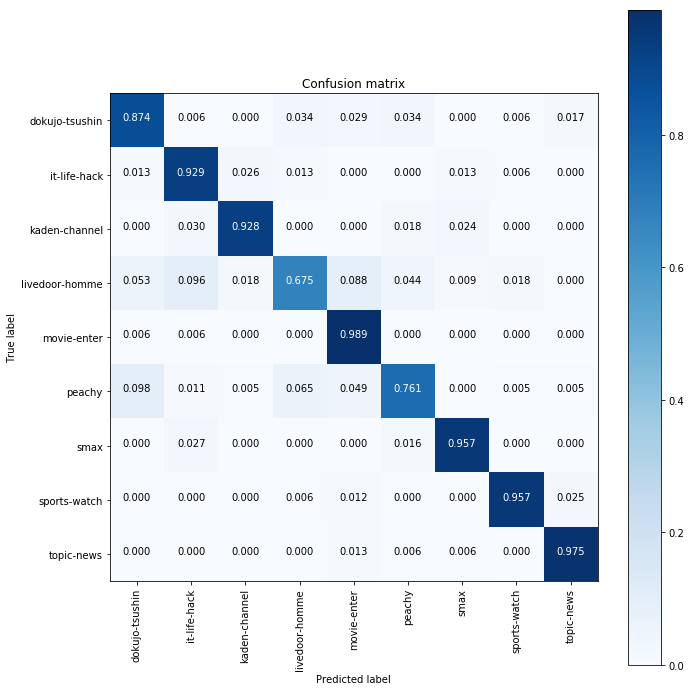

In [14]:
import sys
sys.path.append('..')
from plot_graph import plot_confusion_matrix
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 10,10

conf_mat = confusion_matrix(y_test, pred_values)
plot_confusion_matrix(conf_mat, target_names, normalize=True)

In [19]:
len(y_test)

1474